# ENSO & DJF temperature relationship status

Not symmetric.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Read temp 

### GHCN CAMS

In [2]:
temp_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/.temp/monthlyAverage/T/(Sep%201978)/(Feb%202022)/RANGE/T/3/boxAverage/T/%28Dec-Feb%29VALUES/X/-170/-55/RANGE/Y/14/70/RANGE/X/-170/1.0/-55/GRID/Y/14/1.0/70/GRID/X//longitude/renameGRID/Y//latitude/renameGRID/dods'
ds = xr.open_dataset(temp_url, decode_times=False)
temp = ds.temp
msk = ~np.isnan(temp.isel(T=0).values)

### Berkeley Earth

In [3]:
temp_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.BerkeleyEarth/.TAVG/time//T/renameGRID/monthlyAverage/T/(Sep%201978)/(Feb%202022)/RANGE/T/3/boxAverage/T/%28Dec-Feb%29/VALUES/longitude/-170/-55/RANGE/latitude/14/70/RANGE/dods'
ds = xr.open_dataset(temp_url, decode_times=False)
temp = ds.TAVG
msk = ~np.isnan(temp.isel(T=0).values)

In [4]:
lon2, lat2 = np.meshgrid(temp.longitude, temp.latitude)

## Read Nino 3.4

In [5]:
ds_n34 = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Sep%201978)/(Feb%202022)/RANGE/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/T/3/boxAverage/T/(Dec-Feb)/VALUES/dods', decode_times=False)
# remove mean
n34 = ds_n34.sst - ds_n34.sst.mean('T')

# Regression!

In [6]:
N, ny, nx  = temp.shape
Y = temp.values.reshape((N, nx * ny))
print(N)

44


## Segmented regression for El Nino/La Nina

Predictors are:
1. Intercept
2. Nino 3.4 * (Nino 3.4 > 0)
3. Nino 3.4 * (Nino 3.4 < 0)
4. Trend

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. https://en.wikipedia.org/wiki/Segmented_regression

Same idea, bad execution.
Frankignoul, C., & Kwon, Y.-O. (2022). On the statistical estimation of asymmetrical relationship between two climate variables. Geophysical Research Letters, 49, e2022GL100777. https://doi.org/10.1029/2022GL100777 

In [7]:
ncoeff = 4
coeff_name = ['Intercept', 'Nino 3.4 > 0', 'Nino 3.4 < 0', 'Trend']
coeff_units = ['deg C', 'deg C / deg Nino 3.4 > 0', 'deg C / deg Nino 3.4 < 0', 'deg C / decade']

X = np.full((N, ncoeff), np.nan)

X[:, 0] = 1
X[:, 1] = n34.values * (n34.values >= 0)
X[:, 2] = n34.values * (n34.values <= 0)
# trend units are deg / decade
X[:, 3] = (n34['T'].values - n34['T'].values[0]) / 12 / 10

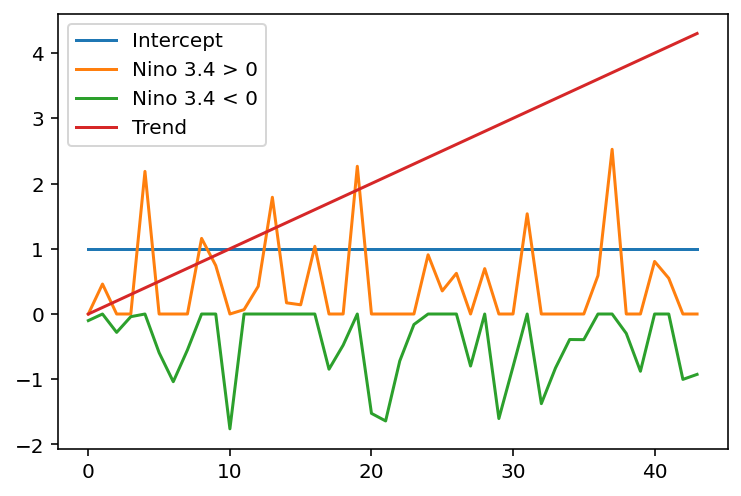

In [8]:
plt.plot(X)
plt.legend(coeff_name)
plt.show()

In [9]:
from numpy.linalg import inv
beta = inv(X.T @ X) @ (X.T@Y)
Yhat = X @ beta

In [10]:
# bootstrap for p-values
mc = 1000
p = np.zeros_like(beta)
p2 = np.zeros((1, ny * nx))
for ii in range(mc):
    idx = np.random.randint(N, size=N)
    beta_fake = inv(X[idx, :].T @ X[idx, :]) @ (X[idx, :].T@Y[idx, :])
    p = p + (beta_fake > 0)
    # the coefficient order is hard coded
    p2 = p2 + ((beta_fake[1, :] - beta_fake[2, :]) > 0)
p = p / mc
p = 2 * np.minimum(p, 1 - p) 
p2 = p2 / mc
p2 = 2 * np.minimum(p2, 1 - p2) 

p = p.reshape((ncoeff, ny, nx))
p2 = p2.reshape((ny, nx))

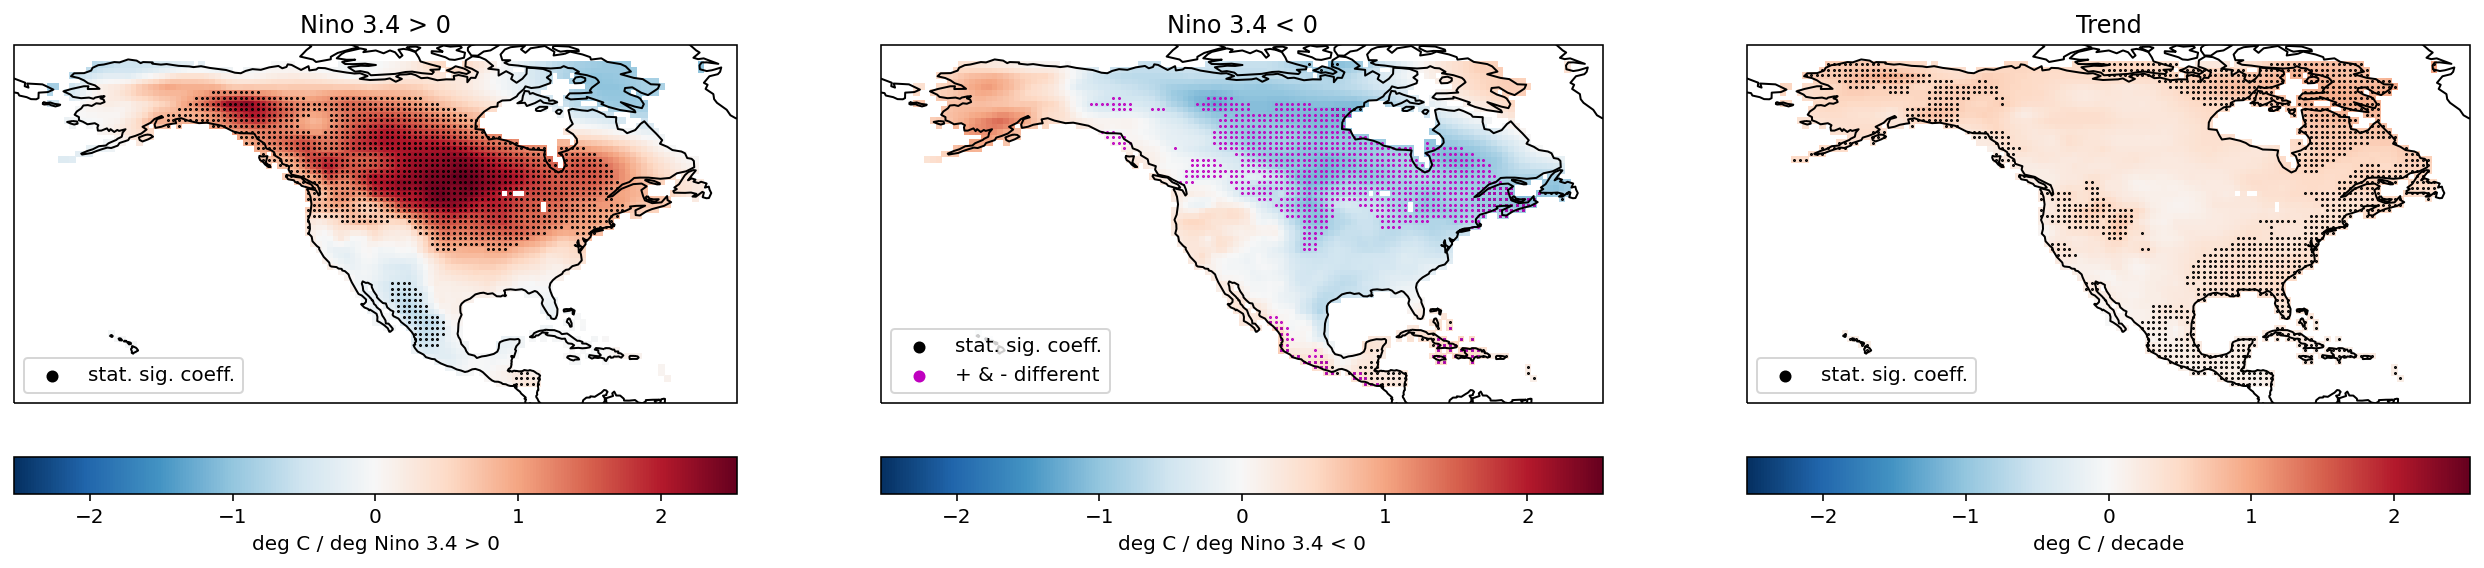

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(22, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for ii,icoeff in enumerate(range(1, ncoeff)):
    ax = axs[ii]
    vmax = np.nanmax(np.abs(beta[1, :]))
    vmin = - vmax
    ax.coastlines()
    g = ax.pcolormesh(temp.longitude, temp.latitude, beta[icoeff, :].reshape((ny, nx)), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    dot = (p[icoeff, :] < 0.05) & msk
    ax.scatter(x=lon2[dot], y=lat2[dot], c='k', s=1, marker='.', label='stat. sig. coeff.')
    if icoeff == 2:
        dot = (p2 < 0.05) & msk
        ax.scatter(x=lon2[dot], y=lat2[dot], c='m', s=1, marker='.', label='+ & - different')
   
    title = coeff_name[icoeff]
    ax.set_title(title)
    ax.legend(loc='lower left', markerscale=10)

    plt.colorbar(g, ax=ax, orientation='horizontal', label=coeff_units[icoeff], pad=0.05)

### Main points
1. No stat. sig. for La Nina.
2. Magenta dots are where the El Nino & La Nina coefficients are stat. sig. different.

Compare with 

Arguez, A., A. Inamdar, M. A. Palecki, C. J. Schreck, and A. H. Young, 2019: ENSO Normals: A New U.S. Climate Normals Product Conditioned by ENSO Phase and Intensity and Accounting for Secular Trends. J. Appl. Meteor. Climatol., 58, 1381–1397, https://doi.org/10.1175/JAMC-D-18-0252.1.

## Regular regression

In [12]:
ncoeff = 3
coeff_name = ['Intercept', 'Nino 3.4',  'Trend']
coeff_units = ['deg C', 'deg C / deg Nino 3.4', 'deg C / decade']

X = np.full((N, ncoeff), np.nan)

X[:, 0] = 1
X[:, 1] = n34.values 
# trend values will be deg / decade
X[:, 2] = (n34['T'].values - n34['T'].values[0]) / 12 / 10

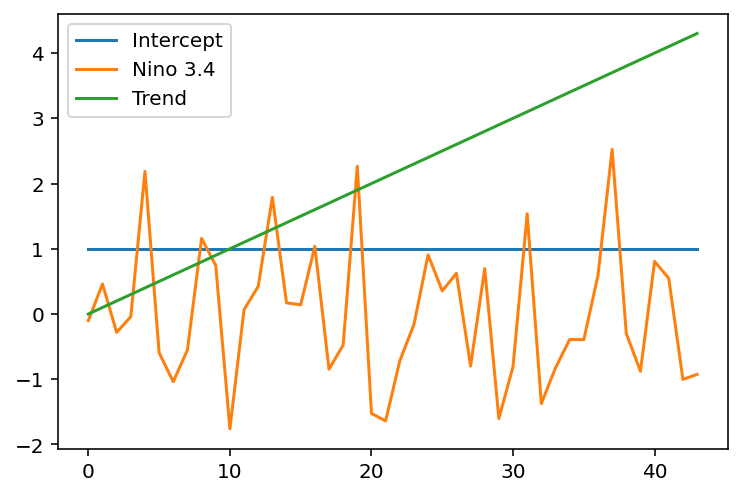

In [13]:
plt.plot(X)
plt.legend(coeff_name)
plt.show()

In [14]:
from numpy.linalg import inv
beta = inv(X.T @ X) @ (X.T@Y)
Yhat = X @ beta

In [15]:
# bootstrap for p-values
mc = 1000
p = np.zeros_like(beta)
p2 = np.zeros((1, ny * nx))
for ii in range(mc):
    idx = np.random.randint(N, size=N)
    beta_fake = inv(X[idx, :].T @ X[idx, :]) @ (X[idx, :].T@Y[idx, :])
    p = p + (beta_fake > 0)
    # the coefficient order is hard coded
    p2 = p2 + ((beta_fake[1, :] - beta_fake[2, :]) > 0)
p = p / mc
p = 2 * np.minimum(p, 1 - p) 
p2 = p2 / mc
p2 = 2 * np.minimum(p2, 1 - p2) 

p = p.reshape((ncoeff, ny, nx))
p2 = p2.reshape((ny, nx))

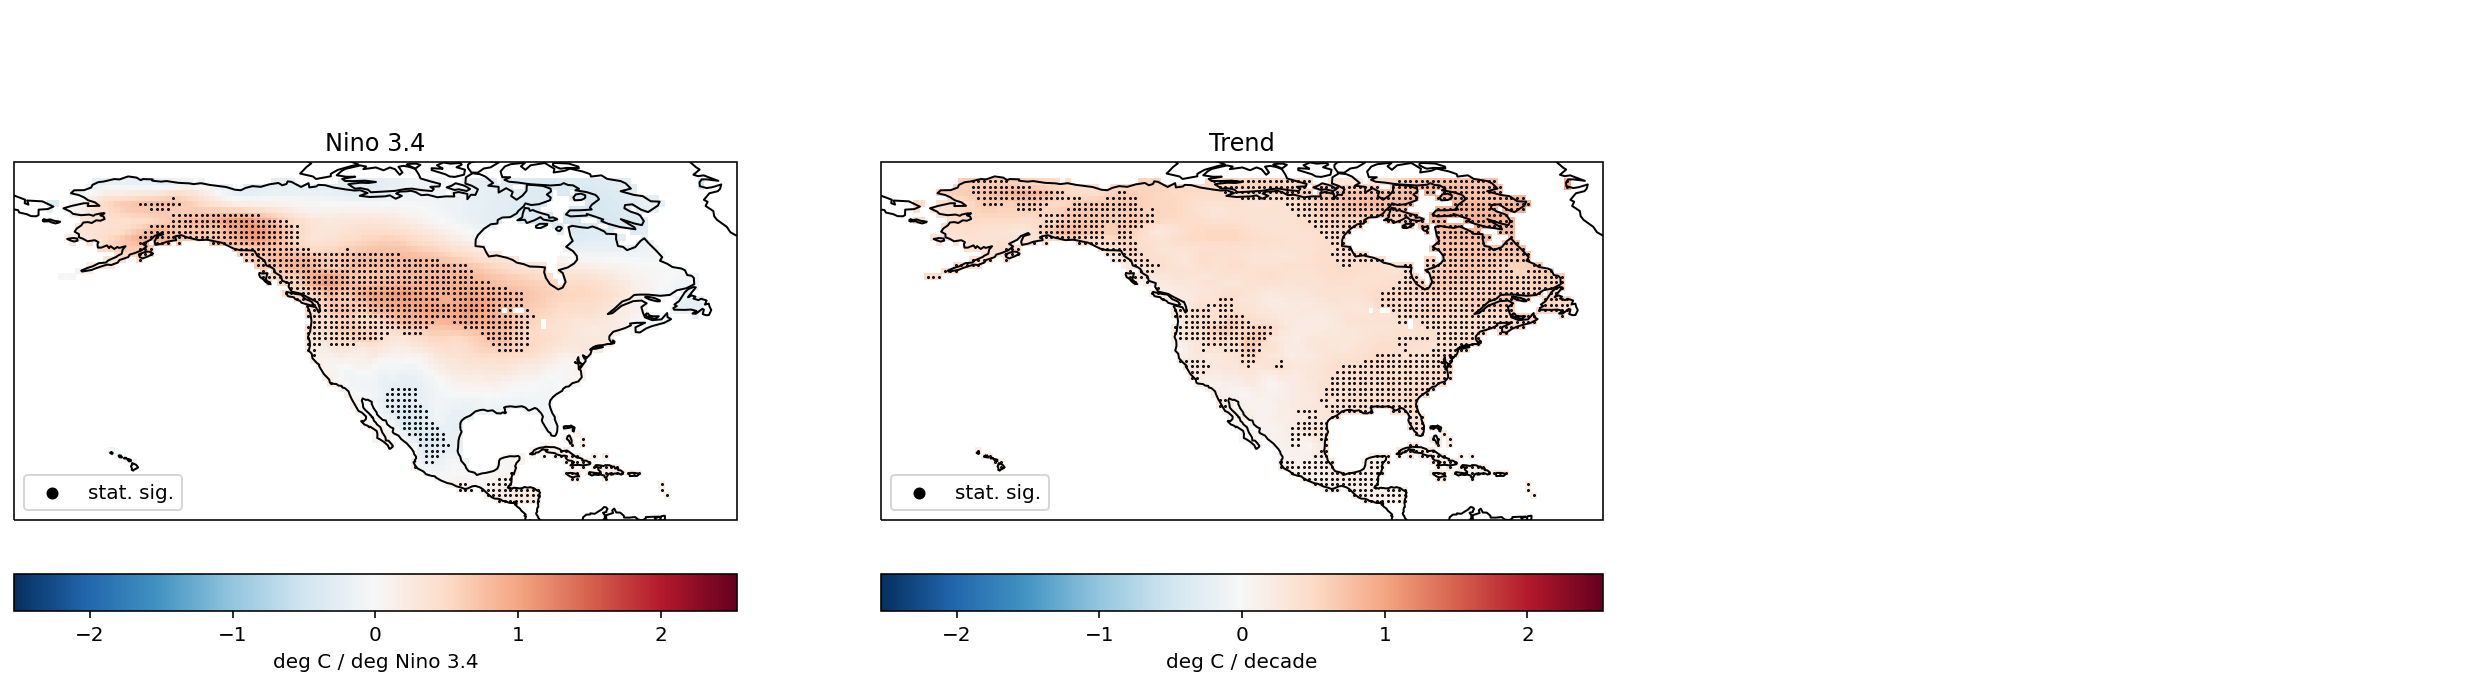

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(22, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for ii,icoeff in enumerate(range(1, ncoeff)):
    ax = axs[ii]
    #vmax = np.nanmax(np.abs(beta[1, :]))
    #vmin = - vmax
    ax.coastlines()
    g = ax.pcolormesh(temp.longitude, temp.latitude, beta[icoeff, :].reshape((ny, nx)), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    dot = (p[icoeff, :] < 0.05) & msk
    ax.scatter(x=lon2[dot], y=lat2[dot], c='k', s=1, marker='.', label='stat. sig.')
    title = coeff_name[icoeff]
    ax.set_title(title)
    ax.legend(loc='lower left', markerscale=10)
    plt.colorbar(g, ax=ax, orientation='horizontal', label=coeff_units[icoeff], pad=0.05)

axs[-1].axis('off')
plt.show()

### Main points
1. There is stat. sig. for Nino 3.4 but the coefficient is muted compared to the positive-only one above.

## Show me the data (in a box)

Look at a box.

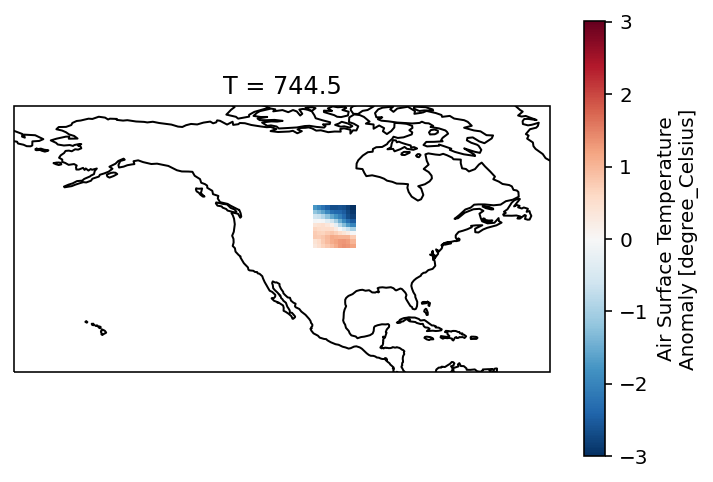

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

box = (np.abs(temp.latitude - 45) < 5) & (np.abs(temp.longitude + 100) < 5)
temp.isel(T=-1).where(box).plot(ax=ax)
ax.coastlines()
plt.show()

In [18]:
t = temp.where(box).mean(['longitude', 'latitude'])

In [19]:
Y = (t - t.mean('T')).values.reshape(N, 1)

ncoeff = 3
coeff_name = ['Intercept', 'Nino 3.4 > 0', 'Nino 3.4 < 0', 'Trend']
coeff_units = ['deg C', 'deg C / deg Nino 3.4 > 0', 'deg C / deg Nino 3.4 < 0', 'deg C / decade']

X = np.full((N, ncoeff), np.nan)

X[:, 0] = 1
X[:, 1] = n34.values * (n34.values >= 0)
X[:, 2] = n34.values * (n34.values <= 0)
# No trend!
# X[:, 3] = (n34['T'].values - n34['T'].values[0]) / 12 / 10

beta = inv(X.T @ X) @ (X.T@Y)
Yhat = X @ beta

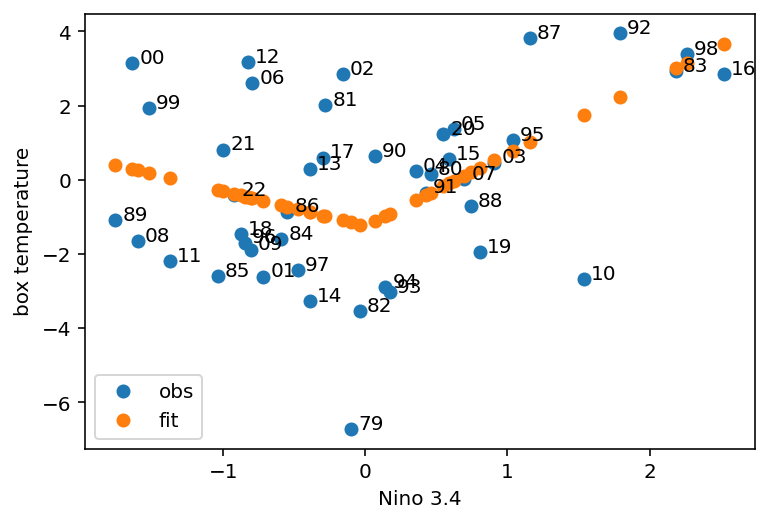

In [20]:
plt.plot(n34, t, 'o', label='obs')
plt.plot(n34, Yhat, 'o', label='fit')
for ii,year in enumerate(np.arange(1979, 2023)):
    plt.text(n34[ii] + 0.05, t[ii], str(year)[2:])
plt.xlabel('Nino 3.4')
plt.ylabel('box temperature')
plt.legend()
plt.show()